In [1]:
# Import Necessary Libraries
import numpy as np
import os, csv, json
import math
import random
import operator
import collections
import pandas as pd

import pprint
import itertools
import matplotlib
from matplotlib import *
from matplotlib import pyplot as plt

from sklearn.decomposition import PCA
import scipy.stats as stats
import scipy.io
from scipy.spatial import distance as Distance

# pretty charting
import seaborn as sns
sns.set_palette('muted')
sns.set_style('darkgrid')

%matplotlib inline

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# First Summarize Kinect Data
Subject 013
ON
Step Length Mean + SD
Cadence Mean + SD
Speed Mean + SD
Var step length + SD
Var Cadence Mean + SD
Var Speed Mean + SD
OFF
Repeat 1-6. 

In [2]:
######## Get list of files (.mat) we want to work with ########
filedir = '../02_StepAnalysis/Processed_StepLength/'
files = []
debug = 0

# get kinect files
for file in os.listdir(filedir):
    if file.endswith('.mat'):
        files.append(file)
    
######## Load in EVENTS struct to find correct events
eparcDir = '../05_Eparc/Processed_Eparc/'
eparcfiles = []
eparcsubjs = {}

# add eparc files
for file in os.listdir(eparcDir):
    if file.endswith('.mat'):
        eparcfiles.append(file)
        eparcsubjs[file.split('_')[1]] = file

# determine which subjects to analyze (e.g. ones with both eparc and kinect)
subjs_to_analyze = []
for file in files:
    subj = file.split('_')[1]
    if subj in eparcsubjs.keys():
        subjs_to_analyze.append([file, eparcsubjs[subj]])

subjs_to_analyze = np.array(subjs_to_analyze)     

# subjects with both pd on/off
onoffsubj = ['012', '013', '014', '015', '016', '017', '020', '021', '022']

print "the subjects with on and off testing were: ", onoffsubj
if debug:
    print "The files we can analyze are: "
    print subjs_to_analyze

the subjects with on and off testing were:  ['012', '013', '014', '015', '016', '017', '020', '021', '022']


## Get Data
For all metrics:
steplength, cadence, speed, stepwidth


In [3]:
stepLength = {}
speed = {}
cadence = {}
steps = {}
stepWidth = {}

for idx, subj in enumerate(subjs_to_analyze):
    filesplit = subj[0].split('_')
    subj_num = str(filesplit[1])
    
    try:
        onoff = int(filesplit[2])
    except:
        onoff = None
        
    # whole file location of each subject's mat file
    kinectfile = filedir+subj[0]
    eparcfile = eparcDir+subj[1]
    
    # load in eparc and kinect data structs
    kinectdata = scipy.io.loadmat(kinectfile)
    kinectdata = kinectdata[sorted(kinectdata.keys())[0]]
    eparcdata = scipy.io.loadmat(eparcfile)
    eparcdata = eparcdata[sorted(eparcdata.keys())[0]]

    ## 01: Load in step lengths and speed as meters  
    eparc_steplength = eparcdata['StepLength'][0][0]/100
    eparc_speed      = eparcdata['Speed'][0][0]/100
    eparc_stepwidth  = eparcdata['StepWidth'][0][0]/100
    
    kinect_steplength = kinectdata['pks'][0][0]
    kinect_speed = kinectdata['velocity'][0][0]
    kinect_cadence = kinectdata['cadence'][0][0]
    kinect_step = len(kinect_steplength)
    
    fullset = 1
    # if there is an on/off pair dataset, handle differently
    if onoff:
        subj_num = subj_num + '-' + str(onoff)

        if len(eparc_steplength) == 18:
            if onoff == 1:
                eparc_steplength = eparc_steplength[0:9]
                eparc_stepwidth = eparc_stepwidth[0:9]
                eparc_speed = eparc_speed[0:9]
            elif onoff == 2:
                eparc_steplength = eparc_steplength[9:18]
                eparc_stepwidth = eparc_stepwidth[9:18]
                eparc_speed = eparc_speed[9:18]
        else: # not full data set from eparc
            fullset = 0
    else:
        ## 01: Load in step lengths
        eparc_steplength = eparcdata['StepLength'][0][0]/100
        eparc_speed      = eparcdata['Speed'][0][0]/100
        eparc_stepwidth  = eparcdata['StepWidth'][0][0]/100

        kinect_stepLength = kinectdata['pks'][0][0]
        kinect_velocity = kinectdata['velocity'][0][0]
        kinect_cadence = kinectdata['cadence'][0][0]
      
    flag = 0
    if any(np.isnan(eparc_steplength)) or any(np.isnan(eparc_speed)) or any(np.isnan(eparc_stepwidth)):
        print "Eparc has nan at: ", subj
        flag = 1
    if any(np.isnan(kinect_steplength)) or any(np.isnan(kinect_speed)) or any(np.isnan(kinect_cadence)):
        print "Kinect has nan at: ", subj
        flag = 1
    
    if flag == 0 and fullset == 1:
        ## 02: Put all data into nested dictionary
        stepLength[subj_num] = {}
        speed[subj_num] = {}
        cadence[subj_num] = {}
        steps[subj_num] = {}
        stepWidth[subj_num] = {}

        stepLength[subj_num]['kinect'] = kinect_steplength
        stepLength[subj_num]['eparc'] = eparc_steplength
        speed[subj_num]['kinect'] = kinect_speed
        speed[subj_num]['eparc'] = eparc_speed
        cadence[subj_num]['kinect'] = kinect_cadence
        steps[subj_num]['kinect'] = kinect_step
        stepWidth[subj_num]['eparc'] = eparc_stepwidth

Eparc has nan at:  ['Subj_002_Step.mat' 'Subj_002_EPARC.mat']
Eparc has nan at:  ['Subj_003_Step.mat' 'Subj_003_EPARC.mat']
Eparc has nan at:  ['Subj_016_2_Step.mat' 'Subj_016_EPARC.mat']
Eparc has nan at:  ['Subj_019_Step.mat' 'Subj_019_EPARC.mat']


In [4]:
# Reorganize into kinect sub dict
kinect_temp = {}
eparc_temp = {}

for subj in stepLength.keys():
    kinect_temp[subj] = {}
    kinect_temp[subj]['stepLength'] = stepLength[subj]['kinect']
    kinect_temp[subj]['speed'] = speed[subj]['kinect']
    kinect_temp[subj]['cadence'] = cadence[subj]['kinect']
    kinect_temp[subj]['steps'] = steps[subj]['kinect']
    
    eparc_temp[subj] = {}
    eparc_temp[subj]['stepLength'] = stepLength[subj]['eparc']
    eparc_temp[subj]['speed'] = speed[subj]['eparc']
    eparc_temp[subj]['stepWidth'] = stepWidth[subj]['eparc']

In [5]:
kinect = {}
eparc = {}

for subj in sorted(kinect_temp.keys()):
    kinect[subj] = {}
    for idx, metric in enumerate(sorted(kinect_temp[subj].keys())):
#         data_to_print = reject_outliers(kinect_temp[subj][metric])
        data_to_print = kinect_temp[subj][metric]
        
        avge = "{0:.3f}".format(np.mean(data_to_print))
        std = "{0:.3f}".format(np.std(data_to_print))
        
        kinect[subj][metric] = [avge, std]
        
for subj in sorted(eparc_temp.keys()):
    eparc[subj] = {}
    for idx, metric in enumerate(sorted(eparc_temp[subj].keys())):
#         data_to_print = reject_outliers(eparc_temp[subj][metric])
        data_to_print = eparc_temp[subj][metric]
        
        avge = "{0:.3f}".format(np.mean(data_to_print))
        std = "{0:.3f}".format(np.std(data_to_print))
        
        eparc[subj][metric] = [avge, std]        

In [6]:
def reject_outliers(data, m = 2.):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
    return data[s<m]

def pretty(d, indent=0):
    for key, value in d.iteritems():
        print '\t' * indent + str(key)
        if isinstance(value, dict):
            pretty(value, indent+1)
        else:
            print '\t' * (indent+1) + str(value)
            
# define patient groups
pdon_firstgroup = ['001', '002', '003', '004', '005', '006', '007'\
              '008', '009', '010']
control_group = ['101', '102', '103', '104', '105', '106', '107', '108', '109', '110',\
                   '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122']
pdoff_group = ['011-1', '012-1', '013-1', '014-1', '015-1',\
                    '016-1', '017-1', '018-1', '019-1', '020-1', '021-1', '022-1']
pdon_secondgroup = ['011-2', '012-2', '013-2', '014-2', '015-2',\
                    '016-2', '017-2', '018-2', '019-2', '020-2', '021-2', '022-2']


## Put Metric Modality Data into CSV File

In [7]:
filename = "table/kinectSubjSummary.csv"

with open(filename, 'w') as output:
    writer = csv.writer(output, lineterminator = '\n')
    writer.writerow(['subject', 'Step Length', '# Steps', 'Speed', 'Cadence'])
    
    for idx, subj in enumerate(sorted(kinect.keys())):
        stepL_avge = kinect[subj]['stepLength'][0]
        stepL_std = kinect[subj]['stepLength'][1]
        step_avge = kinect[subj]['steps'][0]
        step_std = kinect[subj]['steps'][1]
        cadence_avge = kinect[subj]['cadence'][0]
        cadence_std = kinect[subj]['cadence'][1]
        speed_avge = kinect[subj]['speed'][0]
        speed_std = kinect[subj]['speed'][1]
        
        stepL_data = str(stepL_avge) + ' +/- ' + str(stepL_std)
        step_data = str(step_avge)
        speed_data = str(speed_avge) + ' +/- ' + str(speed_std)
        cadence_data = str(cadence_avge) + ' +/- ' + str(cadence_std)
        writer.writerow([subj, stepL_data, step_data, speed_data, cadence_data])
print "finished"

finished


In [8]:
filename = "table/eparcSubjSummary.csv"

with open(filename, 'w') as output:
    writer = csv.writer(output, lineterminator = '\n')
    writer.writerow(['subject', 'Step Length', 'Step Width', 'Speed'])
    
    for idx, subj in enumerate(sorted(eparc.keys())):
        stepL_avge = eparc[subj]['stepLength'][0]
        stepL_std = eparc[subj]['stepLength'][1]
        stepW_avge = eparc[subj]['stepWidth'][0]
        stepW_std = eparc[subj]['stepWidth'][1]
        speed_avge = eparc[subj]['speed'][0]
        speed_std = eparc[subj]['speed'][1]
        
        stepL_data = str(stepL_avge) + ' +/- ' + str(stepL_std)
        stepW_data = str(stepW_avge) + ' +/- ' + str(stepW_std)
        speed_data = str(speed_avge) + ' +/- ' + str(speed_std)
        writer.writerow([subj, stepL_data, stepW_data, speed_data])
print "finished"

finished


# Cross Correlation

In order to do cross-correlation, we need the raw metrics.

In [9]:
stepLength = {}
speed = {}
cadence = {}
steps = {}
stepWidth = {}

for idx, subj in enumerate(subjs_to_analyze):
    filesplit = subj[0].split('_')
    subj_num = str(filesplit[1])
    
    try:
        onoff = int(filesplit[2])
    except:
        onoff = None
        
    # whole file location of each subject's mat file
    kinectfile = filedir+subj[0]
    eparcfile = eparcDir+subj[1]
    
    # load in eparc and kinect data structs
    kinectdata = scipy.io.loadmat(kinectfile)
    kinectdata = kinectdata[sorted(kinectdata.keys())[0]]
    eparcdata = scipy.io.loadmat(eparcfile)
    eparcdata = eparcdata[sorted(eparcdata.keys())[0]]

    ## 01: Load in step lengths and speed as meters  
    eparc_steplength = eparcdata['StepLength'][0][0]/100
    eparc_speed      = eparcdata['Speed'][0][0]/100
    eparc_stepwidth  = eparcdata['StepWidth'][0][0]/100
    
    kinect_steplength = kinectdata['pks'][0][0]
    kinect_speed = kinectdata['velocity'][0][0]
    kinect_cadence = kinectdata['cadence'][0][0]
    kinect_step = len(kinect_steplength)
    
    fullset = 1
    # if there is an on/off pair dataset, handle differently
    if onoff:
        subj_num = subj_num + '-' + str(onoff)

        if len(eparc_steplength) == 18:
            if onoff == 1:
                eparc_steplength = eparc_steplength[0:9]
                eparc_stepwidth = eparc_stepwidth[0:9]
                eparc_speed = eparc_speed[0:9]
            elif onoff == 2:
                eparc_steplength = eparc_steplength[9:18]
                eparc_stepwidth = eparc_stepwidth[9:18]
                eparc_speed = eparc_speed[9:18]
        else: # not full data set from eparc
            fullset = 0
    else:
        ## 01: Load in step lengths
        eparc_steplength = eparcdata['StepLength'][0][0]/100
        eparc_speed      = eparcdata['Speed'][0][0]/100
        eparc_stepwidth  = eparcdata['StepWidth'][0][0]/100

        kinect_stepLength = kinectdata['pks'][0][0]
        kinect_velocity = kinectdata['velocity'][0][0]
        kinect_cadence = kinectdata['cadence'][0][0]
      
    flag = 0
    if any(np.isnan(eparc_steplength)) or any(np.isnan(eparc_speed)) or any(np.isnan(eparc_stepwidth)):
        print "Eparc has nan at: ", subj
        flag = 1
    if any(np.isnan(kinect_steplength)) or any(np.isnan(kinect_speed)) or any(np.isnan(kinect_cadence)):
        print "Kinect has nan at: ", subj
        flag = 1
    
    if flag == 0 and fullset == 1:
        ## 02: Put all data into nested dictionary
        stepLength[subj_num] = {}
        speed[subj_num] = {}
        cadence[subj_num] = {}
        steps[subj_num] = {}
        stepWidth[subj_num] = {}

        stepLength[subj_num]['kinect'] = kinect_steplength
        stepLength[subj_num]['eparc'] = eparc_steplength
        speed[subj_num]['kinect'] = kinect_speed
        speed[subj_num]['eparc'] = eparc_speed
        cadence[subj_num]['kinect'] = kinect_cadence
        steps[subj_num]['kinect'] = kinect_step
        stepWidth[subj_num]['eparc'] = eparc_stepwidth

Eparc has nan at:  ['Subj_002_Step.mat' 'Subj_002_EPARC.mat']
Eparc has nan at:  ['Subj_003_Step.mat' 'Subj_003_EPARC.mat']
Eparc has nan at:  ['Subj_016_2_Step.mat' 'Subj_016_EPARC.mat']
Eparc has nan at:  ['Subj_019_Step.mat' 'Subj_019_EPARC.mat']


In [10]:
# Reorganize into kinect sub dict
kinect_temp = {}
eparc_temp = {}

for subj in stepLength.keys():
    kinect_temp[subj] = {}
    kinect_temp[subj]['stepLength'] = stepLength[subj]['kinect']
    kinect_temp[subj]['speed'] = speed[subj]['kinect']
    kinect_temp[subj]['cadence'] = cadence[subj]['kinect']
    kinect_temp[subj]['steps'] = steps[subj]['kinect']
    
    eparc_temp[subj] = {}
    eparc_temp[subj]['stepLength'] = stepLength[subj]['eparc']
    eparc_temp[subj]['speed'] = speed[subj]['eparc']
    eparc_temp[subj]['stepWidth'] = stepWidth[subj]['eparc']

In [48]:
def lagcorr(x,y,lag=None,verbose=True):
    '''Compute lead-lag correlations between 2 time series.

    <x>,<y>: 1-D time series.
    <lag>: lag option, could take different forms of <lag>:
          if 0 or None, compute ordinary correlation and p-value;
          if positive integer, compute lagged correlation with lag
          upto <lag>;
          if negative integer, compute lead correlation with lead
          upto <-lag>;
          if pass in an list or tuple or array of integers, compute 
          lead/lag correlations at different leads/lags.

    Note: when talking about lead/lag, uses <y> as a reference.
    Therefore positive lag means <x> lags <y> by <lag>, computation is
    done by shifting <x> to the left hand side by <lag> with respect to
    <y>.
    Similarly negative lag means <x> leads <y> by <lag>, computation is
    done by shifting <x> to the right hand side by <lag> with respect to
    <y>.

    Return <result>: a (n*2) array, with 1st column the correlation 
    coefficients, 2nd column correpsonding p values.

    Currently only works for 1-D arrays.
    '''

    import numpy
    from scipy.stats import pearsonr

    if len(x)!=len(y):
#         raise('Input variables of different lengths.')
        if len(x) <= len(y):
            x = np.concatenate((x, np.zeros((len(y)-len(x), 1))))
        else:
            y = np.concatenate((y, np.zeros((len(x)-len(y), 1))))
            
    #--------Unify types of <lag>-------------
    if numpy.isscalar(lag):
        if abs(lag)>=len(x):
            raise('Maximum lag equal or larger than array.')
        if lag<0:
            lag=-numpy.arange(abs(lag)+1)
        elif lag==0:
            lag=[0,]
        else:
            lag=numpy.arange(lag+1)    
    elif lag is None:
        lag=[0,]
    else:
        lag=numpy.asarray(lag)

    #-------Loop over lags---------------------
    results={}
    if verbose:
        print '\n#<lagcorr>: Computing lagged-correlations at lags:',lag

    for ii in lag:
        if ii<0:
            result = pearsonr(x[:ii],y[-ii:])
        elif ii==0:
            result = pearsonr(x,y)
        elif ii>0:
            result = pearsonr(x[ii:],y[:-ii])
            
#         if result[0] > 0.2:
#             print result
        results[str(ii)] = result
        
#     result=numpy.asarray(result)
    return results

In [36]:
cross_corr = {}
lags = np.arange(-10, 10, 1)

# loop through each subject
for subj in kinect_temp.keys():
    kinect_data = kinect_temp[subj]
    eparc_data = eparc_temp[subj]
    cross_corr[subj] = {}
    
    # loop through each metric
    for metric in eparc_data.keys():
        # check if metric in kinect_data
        if metric in kinect_data.keys():
            kinect_metric = kinect_data[metric]
            eparc_metric = eparc_data[metric]
            result = lagcorr(kinect_metric, eparc_metric, lag=lags, verbose=False)
#             break
            cross_corr[subj][metric] = result
#         break
#     break
# print cross_corr#['022-2']['stepLength']

In [37]:
for subj in cross_corr.keys():
    print '\n', subj
    subj_corr = cross_corr[subj]
    for metric in subj_corr.keys():
        print metric, '\t'
        print subj_corr[metric]


022-2
stepLength 	
[]
speed 	
[]

022-1
stepLength 	
[((array([ 0.22190897]), array([ 0.19334318])), -2), ((array([ 0.24016698]), array([ 0.15220358])), 1), ((array([ 0.29960507]), array([ 0.07586136])), 2), ((array([ 0.33169948]), array([ 0.05158247])), 3), ((array([ 0.24223877]), array([ 0.16749166])), 4)]
speed 	
[]

021-1
stepLength 	
[((array([ 0.26613415]), array([ 0.01566164])), 2), ((array([ 0.22777687]), array([ 0.04084538])), 3), ((array([ 0.24324576]), array([ 0.02969137])), 4), ((array([ 0.21671497]), array([ 0.0550644])), 5), ((array([ 0.22112664]), array([ 0.05328079])), 7)]
speed 	
[]

021-2
stepLength 	
[]
speed 	
[((array([ 0.29830695]), array([ 0.00270852])), 7), ((array([ 0.21286367]), array([ 0.03534468])), 8), ((array([ 0.23681667]), array([ 0.01951923])), 9)]

010
stepLength 	
[((array([ 0.32175176]), array([ 0.03772097])), 7), ((array([ 0.32041044]), array([ 0.04111425])), 8), ((array([ 0.41544058]), array([ 0.00767953])), 9)]
speed 	
[((array([ 0.30002241]), ar

In [49]:
cross_corr = {}
lags = np.arange(-5, 5, 1)

# loop through each subject
for subj in kinect_temp.keys():
    kinect_data = kinect_temp[subj]
    eparc_data = eparc_temp[subj]
    cross_corr[subj] = {}
    
    # loop through each metric
    for metric in eparc_data.keys():
        # check if metric in kinect_data
        if metric in kinect_data.keys():
            kinect_metric = kinect_data[metric]
            new_kinect_metric = np.zeros((len(eparc_metric), 1))
            eparc_metric = eparc_data[metric]
            
            winSize = 2*math.ceil(float(len(kinect_metric)) / len(eparc_metric))
            stepSize = winSize / 2
            
            # apply moving average through the kinect_metric
            for ix in range(0, len(new_kinect_metric)):
                indice = ix*stepSize
                if indice+winSize > len(kinect_metric):
                    endindice = len(kinect_metric)
                else:
                    endindice = indice+winSize
                    
                new_kinect_metric[ix] = np.mean(kinect_metric[indice: endindice])
            
            kinect_metric = new_kinect_metric
#             kinect_metric = kinect_metric[0 : len(kinect_metric) : math.ceil(float(len(kinect_metric))/len(eparc_metric))]

            
#             plt.figure()
#             plt.plot(kinect_metric[0:118:118/9])
            
#             plt.figure()
#             plt.plot(eparc_metric)
            
#             break
            result = lagcorr(kinect_metric, eparc_metric, lag=lags, verbose=False)
            cross_corr[subj][metric] = result
#         break
#     break

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:29: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


# Distribution of Correlations
Get a distribution of correlations for each metric, averaged across subjects

In [84]:
metric_cross_corr = {}
metric_pval_corr = {}

for subj in cross_corr.keys():
    subj_corr = cross_corr[subj]
    for metric in subj_corr.keys():
        metric_corr = subj_corr[metric] 
        
        # initialize if haven't yet
        if metric not in metric_cross_corr.keys():
            metric_cross_corr[metric] = {}
            metric_pval_corr[metric] = {}
            
        for lag in metric_corr.keys():
            lag_corr = metric_corr[lag]
            
            if lag not in metric_cross_corr[metric].keys():
                metric_cross_corr[metric][lag] = []
                metric_pval_corr[metric][lag] = []
            
            # get correlation and pvalue
            corr_val = np.ndarray.tolist(lag_corr[0])[0]
            pval = np.ndarray.tolist(lag_corr[1])[0]
            
            if not math.isnan(corr_val):
                metric_cross_corr[metric][lag].append(corr_val)
            if not math.isnan(pval):
                metric_pval_corr[metric][lag].append(pval)
print "Converted dictionary to metrics -> lag -> values"               

# print len(metric_cross_corr['stepLength']['-5'])
# plt.plot(metric_cross_corr['stepLength']['-5'])
# print np.mean(metric_cross_corr['stepLength']['-5'])       
# #         print metric, '\t'
# #         print subj_corr[metric]
# #         print subj_corr[metric][0][0]
# #         plt.figure();
# #         plt.plot(subj_corr[metric])
# #         break
# #     break

Converted dictionary to metrics -> lag -> values


stepLength
Averaged Correlation is  0.0919024628
speed
Averaged Correlation is  0.166567077573


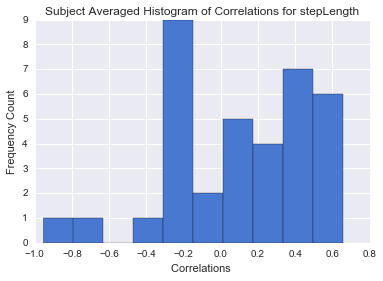

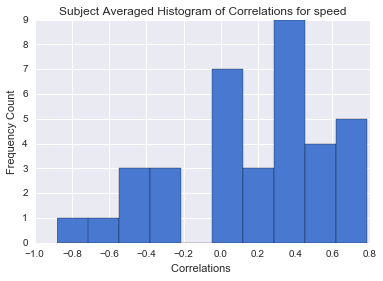

In [97]:
avg_corr = []
for metric in metric_cross_corr.keys():
    lag_corr = metric_cross_corr[metric]
    print metric
    for lag in lag_corr.keys():
        avge_corr = []
        avge_corr.append(metric_cross_corr[metric][lag])
#         plt.hist(metric_cross_corr[metric][lag])
#         print np.mean(metric_cross_corr[metric][lag]) 
        
        if lag == '0':
            print "Averaged Correlation is ", np.mean(metric_cross_corr[metric][lag]) 
            plt.figure()
            plt.hist(metric_cross_corr[metric][lag])
            plt.title('Subject Averaged Histogram of Correlations for ' + metric)
            plt.xlabel('Correlations ')
            plt.ylabel('Frequency Count')